In [ ]:
!pip install segmentation_models
!pip install keras
!pip install tensorflow

from sklearn.model_selection import train_test_split
import os
import random

import tensorflow as tf
import cv2
import numpy as np

from segmentation_models import Unet
from segmentation_models.metrics import iou_score
import segmentation_models as sm
sm.set_framework("tf.keras")
sm.framework()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/MACHINE_LEARNING/DoAn

Mounted at /content/gdrive
/content/gdrive/MyDrive/MACHINE_LEARNING/DoAn


In [ ]:
import os
import shutil
import cv2
import numpy as np
from PIL import Image

from skimage.draw import ellipse

data_path = "NV_public_defects"

def make_map_normal(data_path):
    for folder in os.listdir(data_path):
        if (not folder.endswith("def")) and (not folder.startswith(".")) and (not folder.endswith("mask")):
            print("*" * 10, folder)
            mask_folder = folder + "_mask"
            mask_folder = os.path.join(data_path, mask_folder)
            try:
                shutil.rmtree(mask_folder)
            except:
                pass

            os.mkdir(mask_folder)

            current_folder = os.path.join(data_path, folder)
            for file in os.listdir(current_folder):
                if file.endswith("png"):
                    print(file)
                    current_file = os.path.join(current_folder, file)
                    image = cv2.imread(current_file)
                    w, h = image.shape[0], image.shape[1]
                    mask_image = np.zeros((w, h), dtype=np.uint8)
                    mask_image = Image.fromarray(mask_image)
                    mask_image.save(os.path.join(mask_folder, file))

def draw_defect(file, labels, w, h):
    file_id = int(file.replace(".png", ""))
    label = labels[file_id - 1]
    label = label.replace("\t", "").replace("  ", " ").replace("  ", " ").replace("\n", "")
    label_array = label.split(" ")

    major, minor, angle, x_pos, y_pos = float(label_array[1]), float(label_array[2]), float(label_array[3]), float(
        label_array[4]), float(label_array[5])
    rr, cc = ellipse(y_pos, x_pos, r_radius=minor, c_radius=major, rotation=-angle)

    mask_image = np.zeros((w, h), dtype=np.uint8)

    try:
        mask_image[rr, cc] = 1
    except:
        rr_n = [min(511, rr[i]) for i in rr]
        cc_n = [min(511, cc[i]) for i in cc]
        mask_image[rr_n, cc_n] = 1

    mask_image = np.array(mask_image, dtype=np.uint8)
    mask_image = Image.fromarray(mask_image)

    return mask_image

def make_map_defect(data_path):
    for folder in os.listdir(data_path):
        if (folder.endswith("def")) and (not folder.startswith(".")):
            print("*" * 10, folder)

            mask_folder = folder + "_mask"
            mask_folder = os.path.join(data_path, mask_folder)
            try:
                shutil.rmtree(mask_folder)
            except:
                pass

            os.mkdir(mask_folder)
            current_folder = os.path.join(data_path, folder)
            f = open(os.path.join(current_folder, 'labels.txt'))
            labels = f.readlines()
            f.close()

            for file in os.listdir(current_folder):
                if file.find("(") > -1:
                    os.remove(os.path.join(current_folder, file))
                    continue

                if file.endswith("png"):
                    print(file)
                    current_file = os.path.join(current_folder, file)
                    image = cv2.imread(current_file)
                    w, h = image.shape[0], image.shape[1]
                    mask_image = draw_defect(file, labels, w, h)
                    mask_image.save(os.path.join(mask_folder, file))

make_map_normal(data_path)
make_map_defect(data_path)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
770.png
637.png
132.png
131.png
114.png
707.png
757.png
886.png
911.png
364.png
199.png
8.png
786.png
125.png
499.png
711.png
291.png
585.png
245.png
67.png
180.png
494.png
11.png
63.png
489.png
500.png
483.png
143.png
230.png
196.png
994.png
423.png
493.png
225.png
176.png
112.png
869.png
820.png
747.png
219.png
400.png
228.png
305.png
912.png
158.png
761.png
564.png
690.png
351.png
511.png
79.png
847.png
874.png
313.png
782.png
810.png
705.png
527.png
97.png
789.png
229.png
495.png
148.png
105.png
393.png
359.png
88.png
992.png
953.png
118.png
613.png
156.png
520.png
760.png
829.png
454.png
414.png
150.png
754.png
972.png
929.png
257.png
163.png
534.png
619.png
620.png
7.png
378.png
256.png
********** Class5
232.png
698.png
379.png
532.png
472.png
305.png
460.png
621.png
393.png
624.png
890.png
541.png
642.png
820.png
297.png
444.png
490.png
244.png
47.png
580.png
258.png
785.png
874.png
279.png
419.png
960.png
771.png
427.png


**TRAIN MODEL**

In [ ]:
data_path  = "NV_public_defects"
w, h = 512, 512
batch_size = 16


BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)

class Dataset:
    def __init__(self, image_path, mask_path, w, h):
        self.image_path = image_path
        self.mask_path = mask_path

        self.w = w
        self.h = h

    def __getitem__(self, i):
        image = cv2.imread(self.image_path[i])
        image = cv2.resize(image, (self.w, self.h), interpolation=cv2.INTER_AREA)
        image = preprocess_input(image)

        mask = cv2.imread(self.mask_path[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask, (self.w, self.h), interpolation=cv2.INTER_AREA)

        image_mask = [(image_mask == v) for v in [1]]
        image_mask = np.stack(image_mask, axis=-1).astype('float')

        return image, image_mask

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size,shape, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shape = shape
        self.indexes = np.arange(self.shape)

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

def load_path(data_path):
    # Get normal image and mask
    classes = ['Class1','Class2','Class3','Class4','Class5','Class6']

    normal_image_path = []
    normal_mask_path = []
    for class_ in classes:
        current_folder = os.path.join(data_path, class_)
        for file in os.listdir(current_folder):
            if file.endswith("png") and (not file.startswith(".")):
                image_path = os.path.join(current_folder, file)
                mask_path = os.path.join(current_folder + "_mask", file)
                normal_mask_path.append(mask_path)
                normal_image_path.append(image_path)

    # Get defect image and mask
    defect_image_path = []
    defect_mask_path = []
    for class_ in classes:
        class_ = class_ + "_def"
        current_folder = os.path.join(data_path, class_)
        for file in os.listdir(current_folder):
            if file.endswith("png") and (not file.startswith(".")):
                image_path = os.path.join(current_folder, file)
                mask_path = os.path.join(current_folder + "_mask", file)
                defect_mask_path.append(mask_path)
                defect_image_path.append(image_path)

    idx = random.sample(range(len(normal_mask_path)), len(defect_mask_path))

    normal_mask_path_new = []
    normal_image_path_new = []

    for id in idx:
        normal_image_path_new.append(normal_image_path[id])
        normal_mask_path_new.append(normal_mask_path[id])

    image_path = normal_image_path_new + defect_image_path
    mask_path = normal_mask_path_new + defect_mask_path

    return image_path, mask_path

image_path, mask_path = load_path(data_path)
image_train, image_test, mask_train, mask_test = train_test_split(image_path, mask_path, test_size=0.2)
train_dataset = Dataset(image_train, mask_train, w, h)
test_dataset = Dataset(image_test, mask_test, w, h)

train_loader = Dataloader(train_dataset, batch_size, shape=len(image_train), shuffle=True)
test_loader = Dataloader(test_dataset, batch_size, shape=len(image_test), shuffle=True)

In [ ]:
model = Unet(BACKBONE,encoder_weights="imagenet",classes=1,activation="sigmoid",input_shape=(w,h,3),encoder_freeze=True)
loss_function = sm.losses.categorical_focal_dice_loss
model.compile(optimizer='adam',loss=loss_function,metrics=[iou_score])

85521592/85521592 [==============================] - 4s 0us/step


In [ ]:
# Train model
from keras.callbacks import ModelCheckpoint
filepath = "checkpoint.hdf5"
callback = ModelCheckpoint(filepath,monitor='val_iou_score',verbose=1,save_best_only=True,mode='max')
model.fit_generator(train_loader,validation_data=test_loader, epochs=20, callbacks=[callback])

85521592/85521592 [==============================] - 4s 0us/step


<ipython-input-7-42bd3f3bf6e0>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_loader,validation_data=test_loader, epochs=20, callbacks=[callback])


Epoch 1/20
90/90 [==============================] - ETA: 0s - loss: 0.7462 - iou_score: 0.1637
Epoch 1: val_iou_score improved from -inf to 0.01526, saving model to checkpoint.hdf5
90/90 [==============================] - 135s 905ms/step - loss: 0.7462 - iou_score: 0.1637 - val_loss: 0.9735 - val_iou_score: 0.0153
Epoch 2/20
90/90 [==============================] - ETA: 0s - loss: 0.4036 - iou_score: 0.4385
Epoch 2: val_iou_score improved from 0.01526 to 0.16938, saving model to checkpoint.hdf5
90/90 [==============================] - 77s 849ms/step - loss: 0.4036 - iou_score: 0.4385 - val_loss: 0.7280 - val_iou_score: 0.1694
Epoch 3/20
90/90 [==============================] - ETA: 0s - loss: 0.3353 - iou_score: 0.5126
Epoch 3: val_iou_score did not improve from 0.16938
90/90 [==============================] - 75s 831ms/step - loss: 0.3353 - iou_score: 0.5126 - val_loss: 0.8940 - val_iou_score: 0.0670
Epoch 4/20
90/90 [==============================] - ETA: 0s - loss: 0.2869 - iou_scor

1/1 [==============================] - 0s 23ms/step


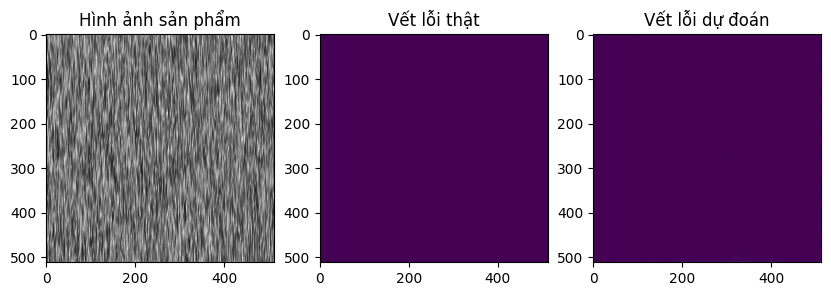

1/1 [==============================] - 0s 24ms/step


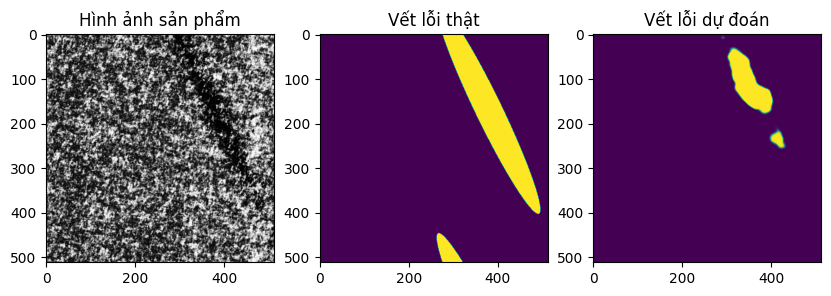

1/1 [==============================] - 0s 23ms/step


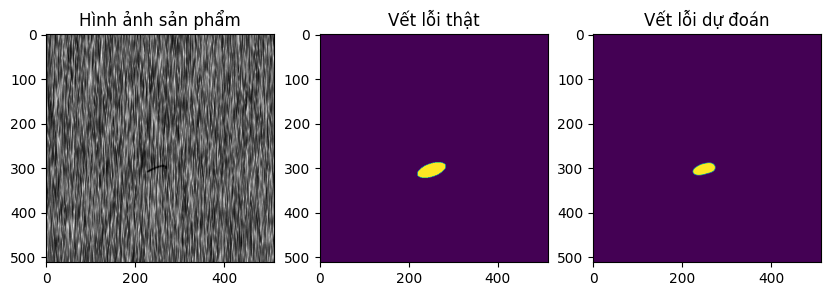

1/1 [==============================] - 0s 23ms/step


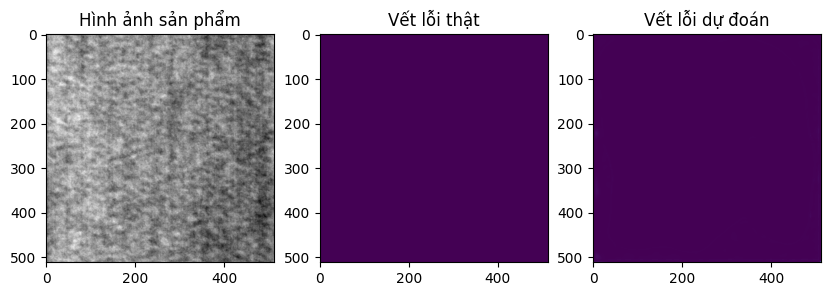

1/1 [==============================] - 0s 36ms/step


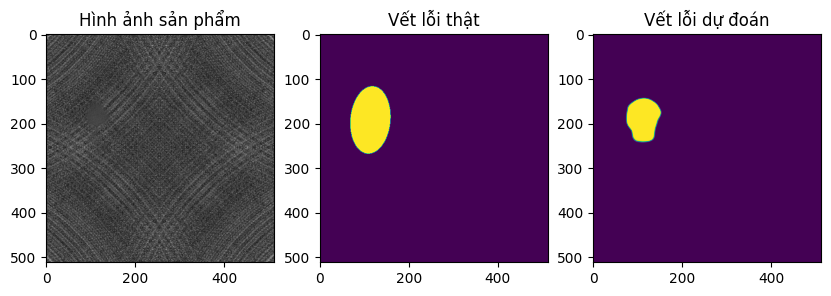

1/1 [==============================] - 0s 39ms/step


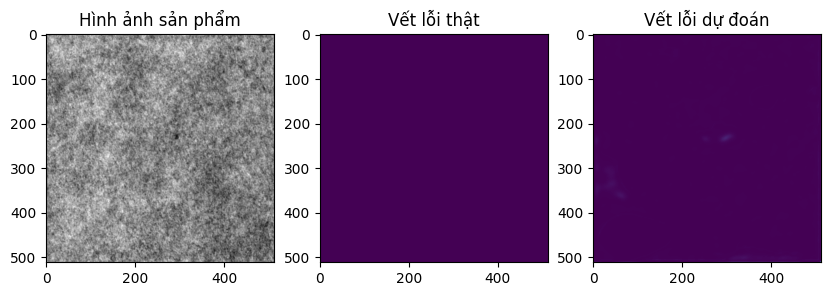

1/1 [==============================] - 0s 24ms/step


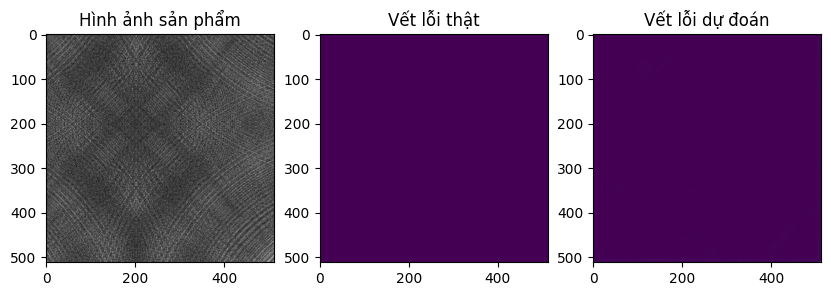

1/1 [==============================] - 0s 27ms/step


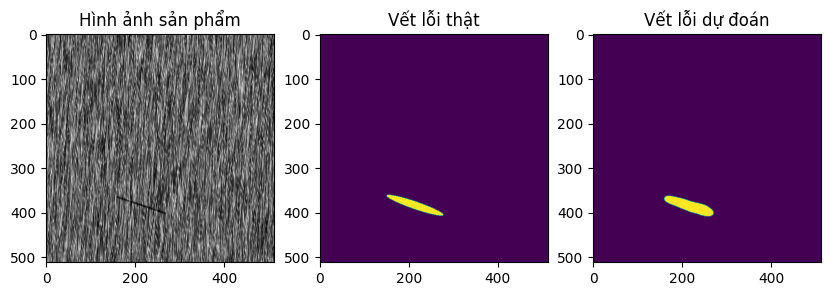

1/1 [==============================] - 0s 35ms/step


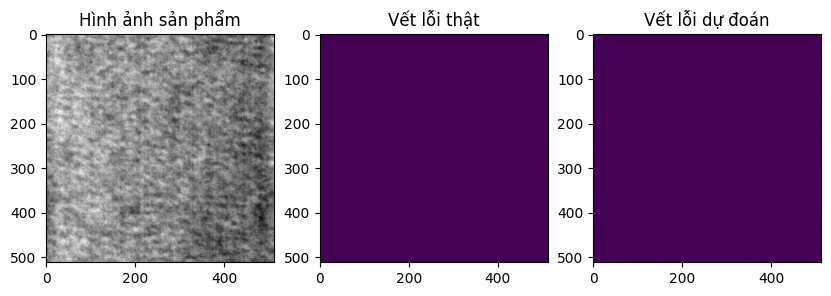

1/1 [==============================] - 0s 24ms/step


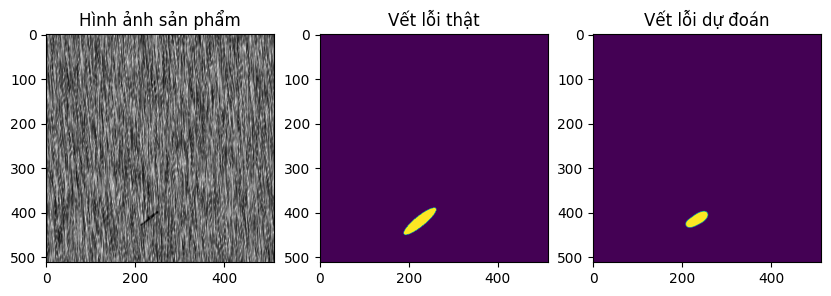

In [ ]:
model.load_weights("checkpoint.hdf5")
ids = range(len(image_test))
index = random.sample(ids, 10)

import matplotlib.pyplot as plt

for id in index:
    image = cv2.imread(image_test[id])
    image = cv2.resize(image, (512, 512))
    mask_predict = model.predict(image[np.newaxis, :, :, :])
    image_mask = cv2.imread(mask_test[id], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512, 512))

    plt.figure(figsize=(10, 6))
    plt.subplot(131)
    plt.title("Hình ảnh sản phẩm")
    plt.imshow(image)
    plt.subplot(132)
    plt.title("Vết lỗi thật")
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.title("Vết lỗi dự đoán")
    z = mask_predict[0] #[:, :, 0]
    plt.imshow(z)
    plt.show()